Nama : Ghiraldy Patrick Toshka Anggawan

NIM  : 202255202062

Mata Kuliah : Pengantar Algoritma Deep Learning

Dosen : Suhardi Aras, S.Kom., M.Kom.

Klasifikasi gambar botol menggunakan CNN dengan EfficientNetB0

Import Necessary Libraries

In [ ]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model

#from tensorflow.keras.layers.experimental import preprocessing
#versi Python dan tensorflow baru tidak memerlukan experimental

# System libraries
from pathlib import Path
import os.path
import random

# Visualization Libraries
import matplotlib.cm as cm
import cv2
import seaborn as sns

sns.set_style('darkgrid')

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [ ]:
pip install keras-preprocessing

In [ ]:
pip install tensorflow

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.19.0


In [ ]:
pip install --upgrade tensorflow

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

--2025-04-14 08:57:41--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2025-04-14 08:57:41 (81.4 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



Load and Transform Data

In [ ]:
BATCH_SIZE = 32
TARGET_SIZE = (300, 300)
#32 adalah jumlah batch yang di proses dalam 1 waktu
#300 adalah jumlah ukuran gambar

In [ ]:
# Walk through each directory
#import os
#from google.colab import drive
#dataset = drive.mount('/content/drive')
#dataset = "/content/drive/MyDrive/Gambar Botol"
#walk_through_dir(dataset);

#Gunakan ini jika ingin agar sistem dapat memeriksa satu persatu direktori yang ada

In [ ]:
# Import libraries lainnya yang diperlukan untuk mengakses data dari Google Drive
import os
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define the function to walk through the directory
# Membuat fungsi untuk memeriksa kedalam masing-masing direktori
def walk_through_dir(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"Directory: {dirpath}")
        print(f"Subdirectories: {dirnames}")
        print(f"Files: {filenames}")
        print("\n")  # bisa tambah baris baru jika ingin proses read lebih baik
                     # namun di code ini saya rasa sudah cukup

# Mengatur path dari dataset
dataset = "/content/drive/MyDrive/Gambar Botol"

# Memanggil fungsi untuk memeriksa ke dalam dataset
walk_through_dir(dataset)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Directory: /content/drive/MyDrive/Gambar Botol
Subdirectories: ['Botol Beer', 'Botol Plastik', 'Botol Soda', 'Botol Air', 'Botol Wine']
Files: ['Klasifikasi Botol CNN.keras', 'Klasifikasi Botol CNN.h5']


Directory: /content/drive/MyDrive/Gambar Botol/Botol Beer
Subdirectories: []
Files: ['00000004.jpg', '00000038.jpg', '00000062.jpg', '00000055.jpg', '00000049.jpg', '00000007.jpg', '00000046.jpg', '00000069.jpg', '00000014.jpg', '00000020.jpg', '00000021.jpg', '00000068.jpg', '00000061.jpg', '00000036.jpg', '00000048.jpg', '00000065.jpg', '00000016.jpg', '00000024.jpg', '00000030.jpg', '00000006.jpg', '00000047.jpg', '00000035.jpg', '00000011.jpg', '00000002.jpg', '00000059.jpg', '00000032.jpg', '00000064.jpg', '00000056.jpg', '00000012.jpg', '00000045.jpg', '00000017.jpg', '00000013.jpg', '00000063.jpg', '00000042.jpg', '00000054.jpg', '00000003.jpg', '0000

Placing Data into a Dataframe

In [ ]:
image_dir = Path(dataset)

# Untuk mendapatkan path dari file dan juga label
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Menggabungkan objek dataframe filepath dan label
image_df = pd.concat([filepaths, labels], axis=1)

<ipython-input-52-9a448dbf108a>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette='dark:salmon_r')


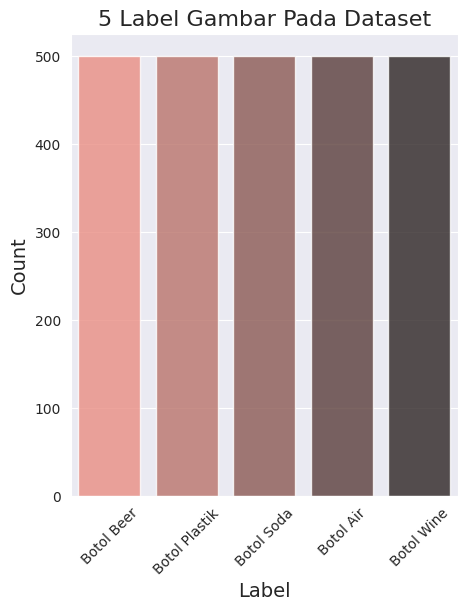

In [ ]:
# Mengambil/Mendapatkan 5 label
label_counts = image_df['Label'].value_counts()[:5]

plt.figure(figsize=(5, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette='dark:salmon_r')
plt.title('5 Label Gambar Pada Dataset', fontsize=16)
plt.xlabel('Label', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45)
plt.show()

Visualizing images from the dataset

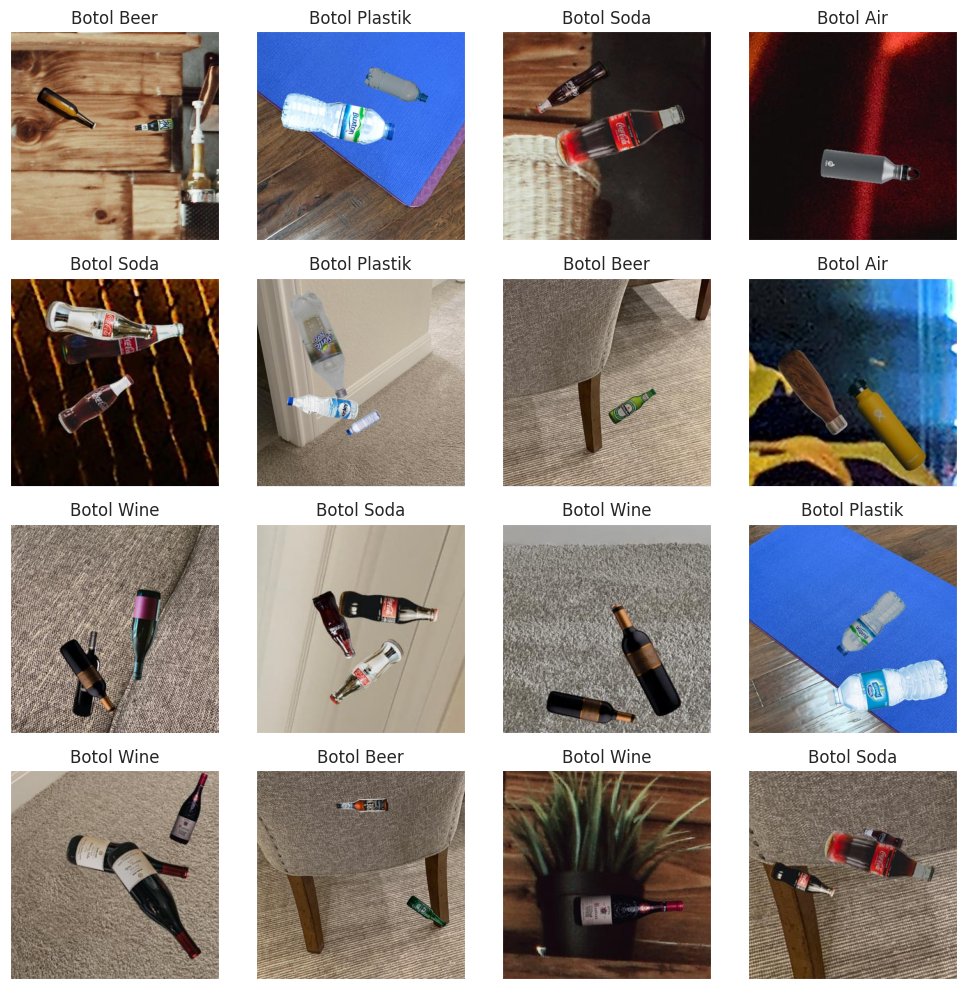

In [ ]:
# Memunculkan 16 Gambar berdasarkan Labelnya
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

Computing Error Rate Analysis

In [ ]:
def compute_ela_cv(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    SCALE = 15
    orig_img = cv2.imread(path)
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)

    cv2.imwrite(temp_filename, orig_img, [cv2.IMWRITE_JPEG_QUALITY, quality])

    # read gambar yang di kompres
    compressed_img = cv2.imread(temp_filename)

    # mendapatkan perbandingan kedua gambar (img1 dan img2) yang dikalikan dengan scale
    diff = SCALE * cv2.absdiff(orig_img, compressed_img)
    return diff


def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    ela_filename = 'temp_ela.png'
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)

    ela_image = ImageChops.difference(image, temp_image)

    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1

    scale = 255.0 / max_diff
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)

    return ela_image


def random_sample(path, extension=None):
    if extension:
        items = Path(path).glob(f'*.{extension}')
    else:
        items = Path(path).glob(f'*')

    items = list(items)

    p = random.choice(items)
    return p.as_posix()

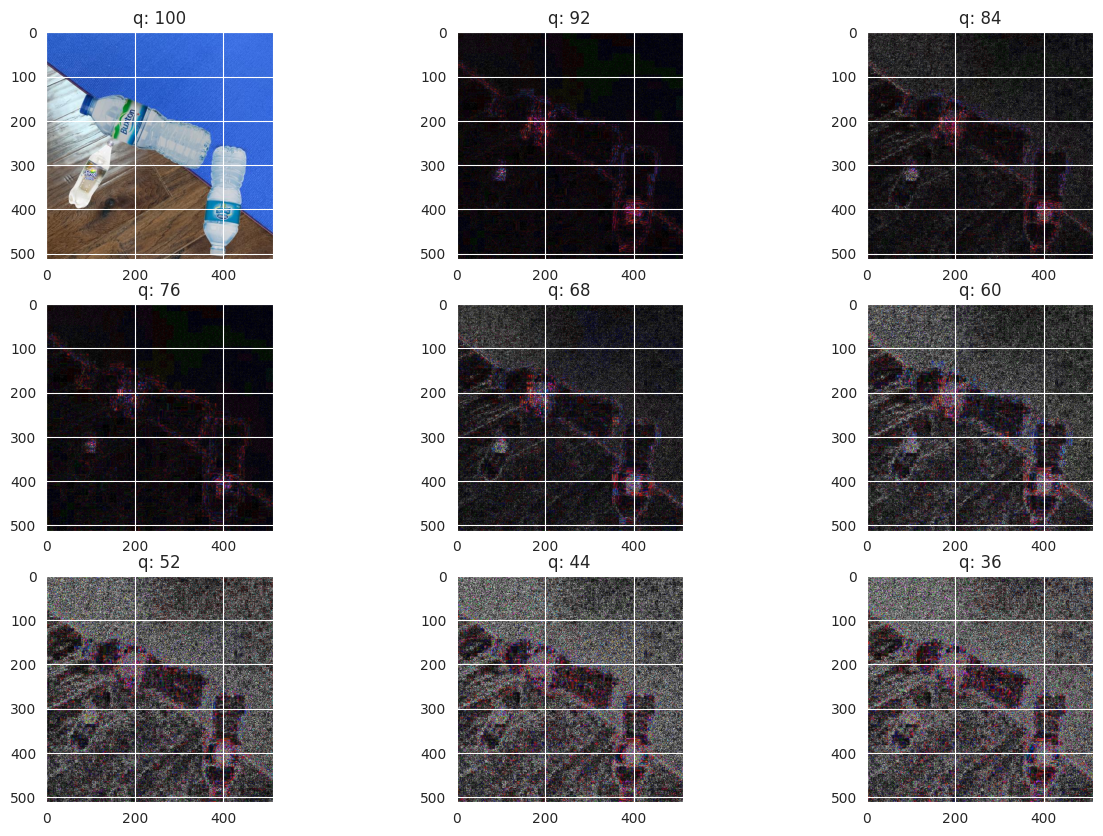

In [ ]:
# Mengambil dan memunculkan gambar random sebagai sample
p = random_sample('/content/drive/MyDrive/Gambar Botol/Botol Plastik')
orig = cv2.imread(p)
orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB) / 255.0
init_val = 100
columns = 3
rows = 3

fig=plt.figure(figsize=(15, 10))
for i in range(1, columns*rows +1):
    quality=init_val - (i-1) * 8
    img = compute_ela_cv(path=p, quality=quality)
    if i == 1:
        img = orig.copy()
    ax = fig.add_subplot(rows, columns, i)
    ax.title.set_text(f'q: {quality}')
    plt.imshow(img)
plt.show()

Data Preprocessing

In [ ]:
# Memisahkan data train dan data test
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)

In [ ]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
)

80% untuk data training (train_df)

20% untuk data testing (test_df)


Dari train_df (80%), dibagi lagi menjadi:

80% × 80% = 64% untuk data training (training)

20% × 80% = 16% untuk data validasi (validation)

In [ ]:
# Membagi data menjadi 3 kategori
# Membaginya menjadi kategori train, validasi, dan test
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 1600 validated image filenames belonging to 5 classes.
Found 400 validated image filenames belonging to 5 classes.
Found 500 validated image filenames belonging to 5 classes.


In [ ]:
# Tahap Melakukan Augmentasi pada Data
augment = tf.keras.Sequential([
    tf.keras.Input(shape=(300, 300, 3)),
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.4),
    tf.keras.layers.RandomTranslation(0.2,0.2),
    tf.keras.layers.RandomContrast(0.4),
    tf.keras.layers.RandomZoom(0.2),
])

Training the model

In [ ]:
# Load Pretrained model (data yang sudah dilatih sebelumnya)
pretrained_model = tf.keras.applications.efficientnet.EfficientNetB0(
    input_shape=(300, 300, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

pretrained_model.trainable = False

In [ ]:
# Membuat Checkpoint Callback
checkpoint_path = "birds_classification_model_checkpoint.weights.h5"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

# Membuat sistem EarlyStopping callback untuk menghentikan proses training jika val_loss dari model tidak ada perubahan hingga epoch ke 5
early_stopping = EarlyStopping(monitor="val_loss",  # untuk memperhatikan metrik dari val_loss
                               patience=5,
                               restore_best_weights=True)  # jika val_loss mengalami penurunan hingga epoch ke 5, maka proses training dihentikan

# Mengatur ReduceLROnPlateau callback untuk menurunkan learning rate ketika val_loss mencapai plateaus

# artinya adalah jika model tidak mengalami peningkatan dalam kinerjanya selama beberapa epoch (misalnya, tidak ada penurunan pada val_loss)
# setelah sejumlah epoch tertentu, maka laju pembelajaran akan dikurangi
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

Batch size: 32

Epochs: 50

Input Shape: (300, 300, 3)

Output layer: 5

In [ ]:
inputs = pretrained_model.input
x = augment(inputs)

x = Dense(128, activation='relu')(pretrained_model.output)
x = Dropout(0.45)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.45)(x)


outputs = Dense(5, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=50,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs",
                                    "botol_classification"),
        checkpoint_callback,
        reduce_lr
    ]
)

Saving TensorBoard log files to: training_logs/botol_classification/20250414-085842


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 49s 481ms/step - accuracy: 0.2250 - loss: 6.6655 - val_accuracy: 0.4725 - val_loss: 1.3298 - learning_rate: 1.0000e-04
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 17s 247ms/step - accuracy: 0.3123 - loss: 2.0632 - val_accuracy: 0.5750 - val_loss: 1.1937 - learning_rate: 1.0000e-04
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 258ms/step - accuracy: 0.3844 - loss: 1.4800 - val_accuracy: 0.6425 - val_loss: 1.0749 - learning_rate: 1.0000e-04
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 249ms/step - accuracy: 0.4599 - loss: 1.3281 - val_accuracy: 0.6775 - val_loss: 0.9747 - learning_rate: 1.0000e-04
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 242ms/step - accuracy: 0.5012 - loss: 1.2278 - val_accuracy: 0.7525 - val_loss: 0.8243 - learning_rate: 1.0000e-04
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 243ms/step - accuracy: 0.5271 - loss: 1.1433 - val_accuracy: 0.8050 - val_loss: 0.7076 - learning_rate: 1.0000e-04
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 242ms/step - acc

Model Evaluation

In [ ]:
results = model.evaluate(test_images, verbose=0)
# Tidak ada output yang ditampilkan selama evaluasi
# proses evaluasi akan dilakukan tanpa menampilkan informasi di konsol

print("Test Loss    : {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

Test Loss    : 0.11229
Test Accuracy: 95.80%


Visualizing loss curves

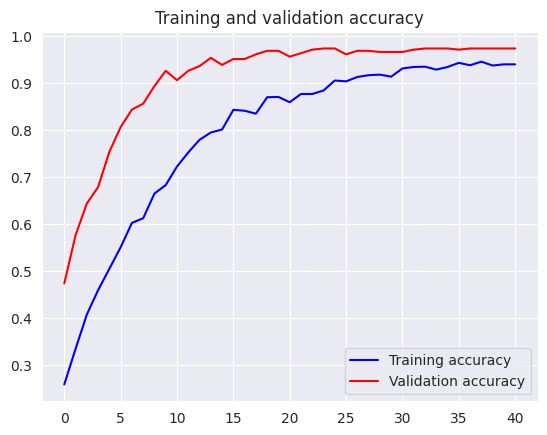

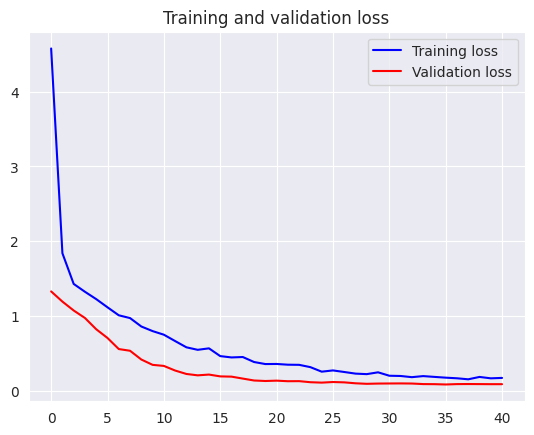

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')

plt.title('Training and validation loss')
plt.legend()
plt.show()

Making predictions on the Test Data

In [ ]:
# Prediksi label dari test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Mapping pada label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Menampilkan hasil
print(f'Hasil Prediksi 5 Pertama: {pred[:5]}')

16/16 ━━━━━━━━━━━━━━━━━━━━ 16s 616ms/step
Hasil Prediksi 5 Pertama: ['Botol Soda', 'Botol Soda', 'Botol Soda', 'Botol Wine', 'Botol Air']


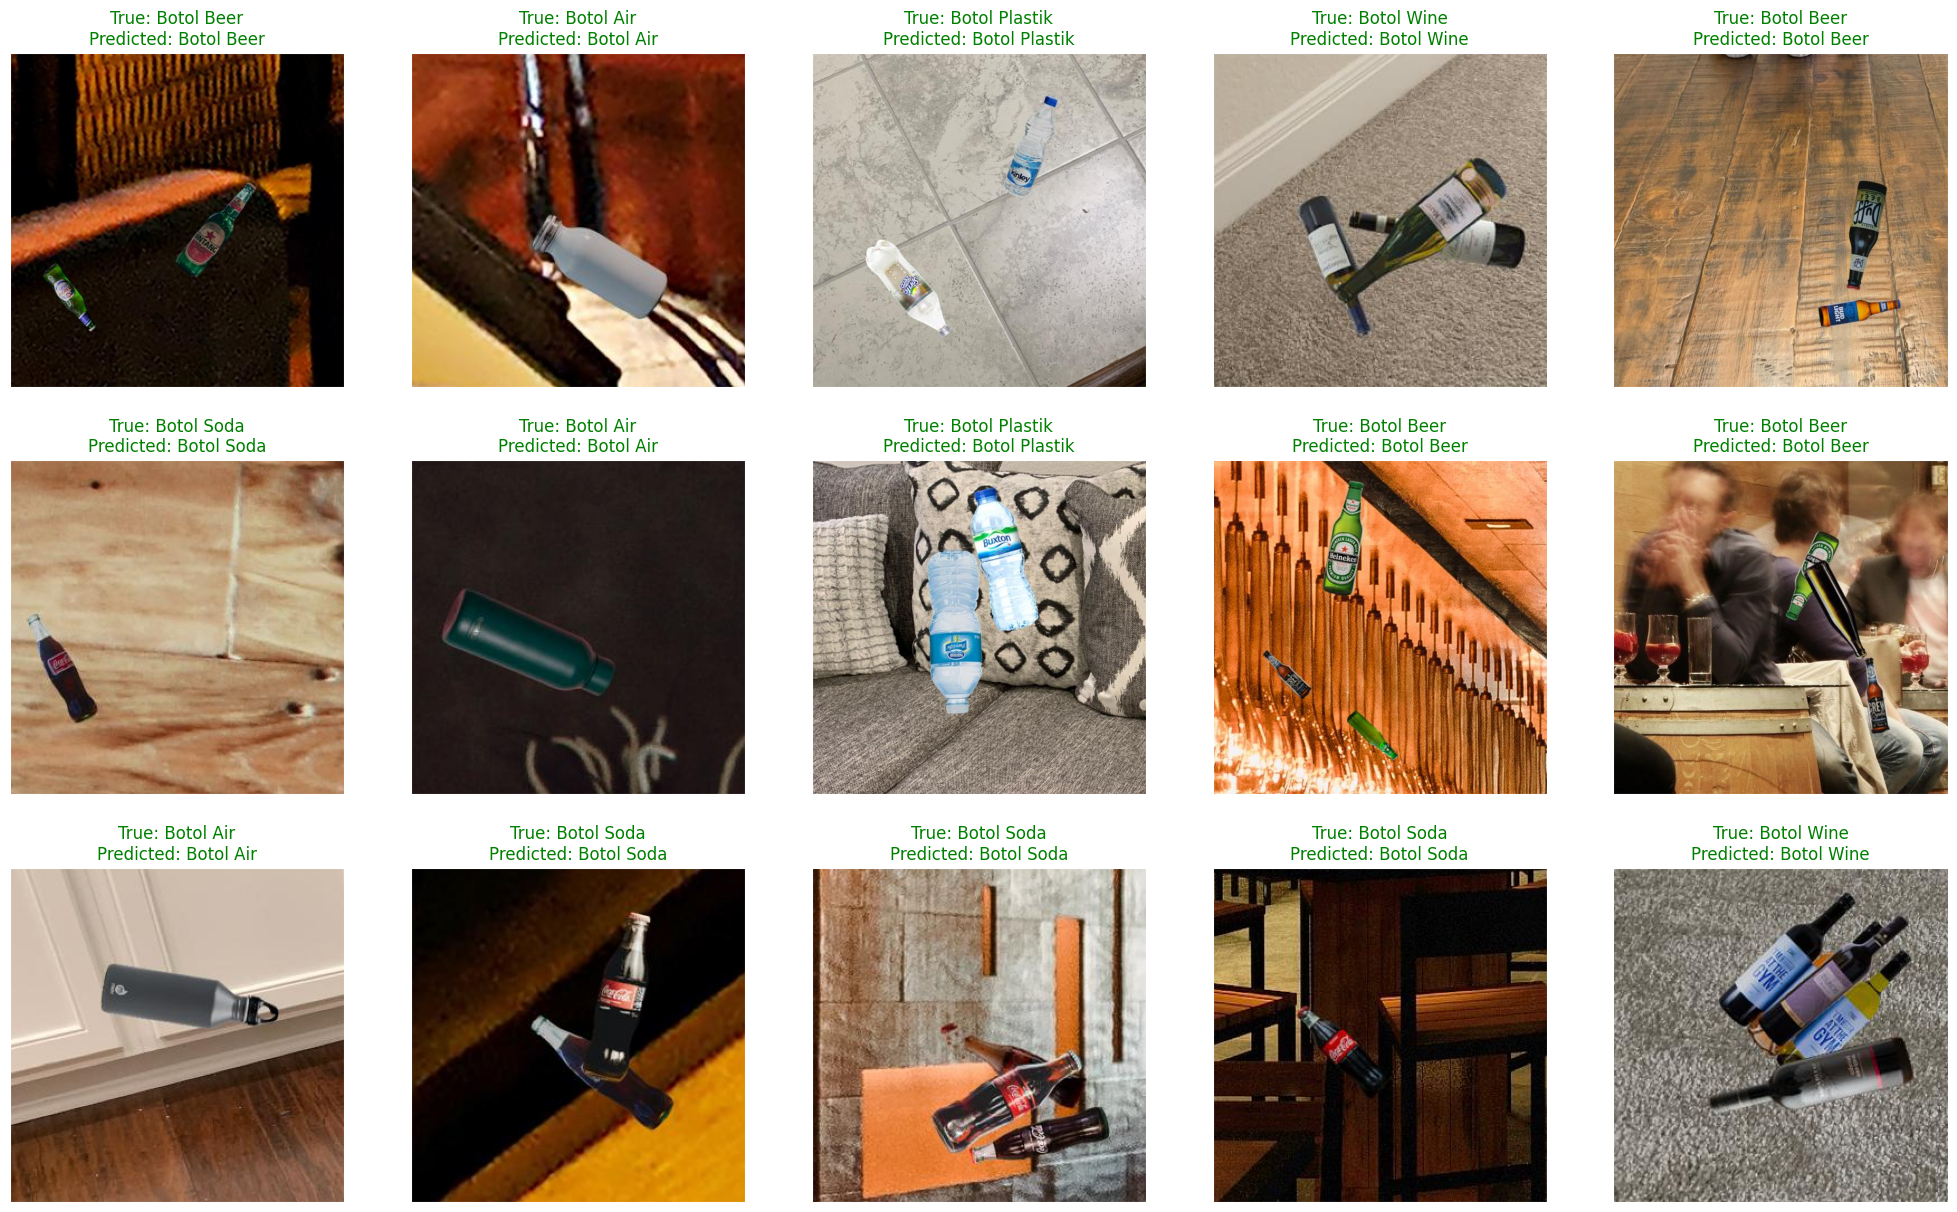

<Figure size 640x480 with 0 Axes>

In [ ]:
# Menampilkan 25 gambar random dari dataset dengan label masing-masing
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

Grad-Cam Visualization

In [ ]:
def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size "size"
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
#     display(Image(cam_path))

    return cam_path


preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

last_conv_layer_name = "top_conv"
img_size = (300,300, 3)

# Remove last layer's softmax
model.layers[-1].activation = None

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_276']]
Received: inputs=Tensor(shape=(1, 300, 300, 3))
  warnings.warn(msg)
<ipython-input-68-893b696883be>:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  jet = cm.get_cmap("jet")


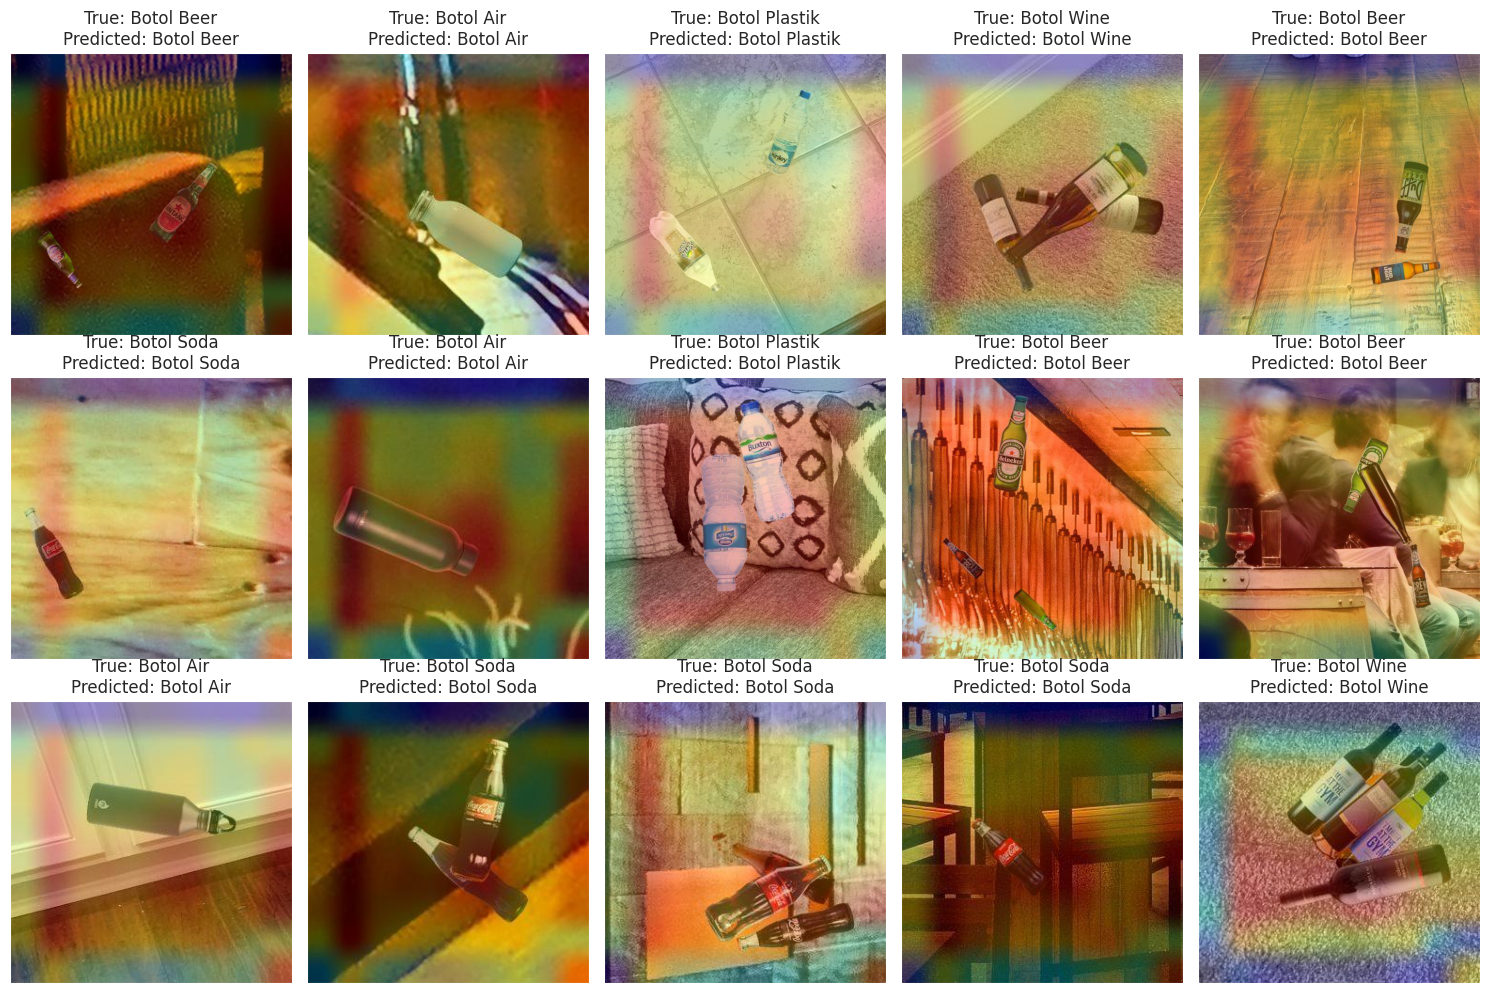

In [ ]:
# Display the part of the pictures used by the neural network to classify the pictures
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    img_path = test_df.Filepath.iloc[random_index[i]]
    img_array = preprocess_input(get_img_array(img_path, size=img_size))
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    cam_path = save_and_display_gradcam(img_path, heatmap)
    ax.imshow(plt.imread(cam_path))
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}")
plt.tight_layout()
plt.show()